In [12]:
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, MessagesState
from langgraph.prebuilt import ToolNode, tools_condition

In [14]:
# 1. 도시별 관광명소 도구
@tool
def get_attractions(city: str) -> list[str]:
    """
    주어진 도시의 인기 관광명소 5곳을 반환합니다.
    """
    sample = {
        "파리": ["에펠탑", "루브르박물관", "노트르담 대성당", "몽마르트 언덕", "개선문"],
        "도쿄": ["도쿄타워", "센소지", "시부야 스크램블", "신주쿠 교엔", "아키하바라"],
        "뉴욕": ["타임스퀘어", "자유의 여신상", "센트럴파크", "엠파이어 스테이트 빌딩", "브로드웨이"],
    }
    return sample.get(city, ["정보가 없습니다"])

# 2. 항공권 가격 도구
@tool
def get_flight_price(depart: str, arrive: str, date: str) -> str:
    """
    출발지→도착지, 날짜별 예상 항공권 가격을 반환합니다.
    """
    # 주요 도시 간 기본 가격 (원화)
    prices = {
        ("서울", "도쿄"): 350000,
        ("서울", "파리"): 1200000,
        ("서울", "뉴욕"): 1500000,
        ("도쿄", "파리"): 1100000,
        ("뉴욕", "파리"): 800000,
    }
    
    # 경로 확인
    route = (depart, arrive)
    if route in prices:
        price = prices[route]
        return f"{depart}에서 {arrive}까지 {date} 항공편 예상 가격은 {format(price, ',')}원입니다."
    else:
        return f"죄송합니다. {depart}에서 {arrive}로 가는 항공편 정보가 없습니다."


# 3. 여행 일정 추천 도구
@tool
def make_itinerary(city: str, days: int) -> str:
    """city에서 days일간 추천 일정을 반환합니다."""
    # 주요 도시별 일정 아이디어
    city_activities = {
        "파리": [
            "에펠탑 방문", "루브르 박물관 관람", "노트르담 대성당 구경", 
            "몽마르트 언덕 산책", "개선문 방문", "세느강 크루즈", 
            "샹젤리제 쇼핑", "베르사유 궁전 투어", "오르세 미술관"
        ],
        "도쿄": [
            "메이지 신궁 방문", "시부야 스크램블 구경", "센소지 사원", 
            "도쿄 타워", "하라주쿠 쇼핑", "긴자 탐방", 
            "아키하바라 전자상가", "스미다강 크루즈", "신주쿠 교엔 공원"
        ],
        "뉴욕": [
            "타임스퀘어 구경", "센트럴 파크 산책", "자유의 여신상 방문", 
            "엠파이어 스테이트 빌딩", "브로드웨이 쇼 관람", "메트로폴리탄 미술관",
            "소호 지역 쇼핑", "브루클린 브릿지 산책", "첼시 마켓 방문"
        ]
    }
    
    # 도시 정보가 있는지 확인
    if city not in city_activities:
        return "해당 도시의 일정 정보가 없습니다."
    
    # 해당 도시의 활동 목록
    activities = city_activities[city]
    
    # 포맷팅된 문자열로 일정 생성
    result = f"## {city} {days}일 추천 여행 일정\n\n"
    
    for day in range(1, days + 1):
        # 아침/점심/저녁 활동 선택 (순환하면서)
        morning = activities[(day * 3 - 3) % len(activities)]
        afternoon = activities[(day * 3 - 2) % len(activities)]
        evening = activities[(day * 3 - 1) % len(activities)]
        
        result += f"### Day {day}\n"
        result += f"- 아침: {morning}\n"
        result += f"- 점심: {city} 현지 레스토랑에서 점심\n"
        result += f"- 오후: {afternoon}\n"
        result += f"- 저녁: {evening} 후 저녁 식사\n\n"
    
    return result


In [15]:
# 4. 최종적으로 사용할 도구 목록
tools = [get_attractions, get_flight_price, make_itinerary]

2.도구 사용을 위한 LLM 준비 및 어시스턴트 정의

In [ ]:
# 1. LLM 바인딩 

llm = ChatOpenAI(model="gpt-4o-mini",base_url="",api_key="")
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

# 2. 시스템 메시지로 역할 지정
sys_msg = SystemMessage(content="당신은 여행 계획을 도와주는 여행 전문 에이전트입니다. 사용자의 요청을 이해하고 적절한 도구를 순차적으로 사용하여 여행 계획을 세워주세요.")

# 3.assistant 노드 정의
def assistant(state: MessagesState):
    messages = [sys_msg] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

# 4.ToolNode 생성
tool_node = ToolNode(tools)

3.멀티턴 대화를 지원하는 상태 기반 그래프 만들기

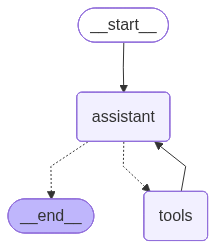

In [17]:
builder = StateGraph(MessagesState)
builder.add_node("assistant", assistant)
builder.add_node("tools", tool_node)

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")

graph = builder.compile()
graph

4.실제 여행 요청에 대한 그래프 실행 및 결과 출력

In [18]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content=
    "첫째, 파리의 상위 5개 관광명소를 알려줘. "
    "그다음, 서울→파리 2025-06-01 항공권 예상 가격을 알려주고, "
    "마지막으로 파리 3일 일정 추천해줘."
)]
result = graph.invoke({"messages": messages})

for msg in result["messages"]:
    msg.pretty_print()

================================ Human Message =================================

첫째, 파리의 상위 5개 관광명소를 알려줘. 그다음, 서울→파리 2025-06-01 항공권 예상 가격을 알려주고, 마지막으로 파리 3일 일정 추천해줘.
================================== Ai Message ==================================
Tool Calls:
  get_attractions (call_7bkhDvlTIc6qYDfYcOqFgaDk)
 Call ID: call_7bkhDvlTIc6qYDfYcOqFgaDk
  Args:
    city: Paris
================================= Tool Message =================================
Name: get_attractions

["정보가 없습니다"]
================================== Ai Message ==================================
Tool Calls:
  get_attractions (call_Po2HglUyVyuO2tWOHcFdNFTT)
 Call ID: call_Po2HglUyVyuO2tWOHcFdNFTT
  Args:
    city: 파리
================================= Tool Message =================================
Name: get_attractions

["에펠탑", "루브르박물관", "노트르담 대성당", "몽마르트 언덕", "개선문"]
================================== Ai Message ==================================
Tool Calls:
  get_flight_price (call_BH65IldFW6d0rzYyvT1qd11p)
 Call ID:

5.실시간 멀티턴 대화를 지원하는 챗봇 루프 만들기

In [19]:
state = {"messages": []}

print("여행 챗봇이 준비되었습니다. (종료하려면 'exit', 'bye', '종료' 입력)")

while True:
    user_input = input("You: ")
    if user_input.strip().lower() in ("종료", "exit", "bye", "q"):
        print("챗봇: 대화를 종료합니다. 안녕히 가세요!")
        break

    # 유저 입력을 state에 추가
    state["messages"].append(HumanMessage(content=user_input))

    # graph.invoke → 상태를 유지하면서 호출
    state = graph.invoke(state)

    # 마지막 AIMessage만 보여주기 (최신 응답)
    for msg in reversed(state["messages"]):
        if msg.type == "ai":
            print(f"챗봇: {msg.content}")
            break

여행 챗봇이 준비되었습니다. (종료하려면 'exit', 'bye', '종료' 입력)
챗봇: 도쿄에서 추천하는 인기 관광지는 다음과 같습니다:

1. 도쿄타워
2. 센소지
3. 시부야 스크램블
4. 신주쿠 교엔
5. 아키하바라

이 장소들을 꼭 방문해보세요! 추가로 궁금한 것이 있으신가요?
챗봇: 여행할 날짜를 알려주시면 서울에서 뉴욕까지의 항공권 가격을 확인해 드리겠습니다. 날짜를 입력해 주세요!
챗봇: 서울에서 뉴욕까지의 항공권 예상 가격은 1,500,000원입니다. 추가로 도움이 필요하시거나 다른 질문이 있으시면 말씀해 주세요!
챗봇: 루브르 박물관 근처의 맛집을 추천하기 위해서는 파리의 인기 관광지를 알아보는 것이 좋습니다. 아래는 파리의 인기 관광지 목록입니다:

1. 에펠탑
2. 루브르 박물관
3. 노트르담 대성당
4. 몽마르트 언덕
5. 개선문

이 중에서 루브르 박물관 근처에는 다양한 맛집이 있습니다. 대표적인 맛집 몇 곳을 추천해 드리자면:

1. **Le Fumoir** - 현대적인 프랑스 요리를 즐길 수 있는 레스토랑으로, 루브르 박물관과 가까운 위치에 있습니다.
2. **Cafe Marly** - 루브르 박물관의 아름다운 전망을 감상하며 식사를 할 수 있는 카페입니다.
3. **Angelina** - 유명한 핫 초콜릿과 디저트가 유명한 카페로, 루브르에서 도보 거리에 위치합니다.

이 외에도 더 많은 정보나 다른 종류의 맛집을 원하시면 말씀해 주세요!
챗봇: 대화를 종료합니다. 안녕히 가세요!
